# **Required Installation**

In [ ]:
!pip install playwright
!playwright install

import nltk
nltk.download('all')

Playwright Host validation warning: 
╔══════════════════════════════════════════════════════╗
║ Host system is missing dependencies to run browsers. ║
║ Missing libraries:                                   ║
║     libwoff2dec.so.1.0.2                             ║
║     libgstgl-1.0.so.0                                ║
║     libgstcodecparsers-1.0.so.0                      ║
║     libavif.so.13                                    ║
║     libharfbuzz-icu.so.0                             ║
║     libenchant-2.so.2                                ║
║     libsecret-1.so.0                                 ║
║     libhyphen.so.0                                   ║
║     libmanette-0.2.so.0                              ║
╚══════════════════════════════════════════════════════╝
    at validateDependenciesLinux (/usr/local/lib/python3.11/dist-packages/playwright/driver/package/lib/server/registry/dependencies.js:216:9)
    at process.processTicksAndRejections (node:internal/process/task_queues:105

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

# **Importing Libraries**

In [ ]:
import re
import time
import nltk
import spacy
import random
import asyncio
import pandas as pd
import nest_asyncio
from collections import Counter
from playwright.async_api import async_playwright
from nltk.sentiment import SentimentIntensityAnalyzer

# **Scrapping Reviews**

In [ ]:
nest_asyncio.apply()

def clean_review(text):
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'by .* on \w+ \d{2}, \d{4} Verified Buyer', '', text)  # Remove the verified buyer date
    if re.fullmatch(r'\d{1,2}-[A-Za-z]{3}-\d{2}|\w{3,9} \d{1,2}, \d{4}', text):
        return None  # If the text is a date pattern, return None
    text = re.sub(r'\b\w{3,9} \d{1,2}, \d{4}\b', '', text)  # Remove other date patterns
    text = re.sub(r'Most Helpful (Positive|Critical) Review \(\d+\)', '', text)
    return text.strip()

# Async function to extract reviews for a product
async def get_snapdeal_reviews(url):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        try:
            await page.goto(url, timeout=90000)

            try:
                product_name = await page.locator("h1").text_content(timeout=60000)
                product_name = product_name.strip() if product_name else "Unknown Product"
            except Exception:
                product_name = "Unknown Product"

            reviews = set()
            for page_num in range(1, 4):  # Pages 1 to 3
                for rate_filter_value in range(1, 6):  # Ratings 1 to 5
                    if len(reviews) >= 10:
                        break

                    filter_url = f"{url}/reviews?page={page_num}&sortBy=HELPFUL&rateFilter={rate_filter_value}"
                    await page.goto(filter_url, timeout=60000)
                    await page.wait_for_load_state("domcontentloaded", timeout=60000)

                    page_reviews = await page.locator(".user-review").all_text_contents()
                    for review in page_reviews:
                        cleaned = clean_review(review)
                        if cleaned:
                            reviews.add(cleaned)
                        if len(reviews) >= 10:
                            break

                if len(reviews) >= 10:
                    break

            await browser.close()
            return product_name, list(reviews)[:10]

        except Exception as e:
            print(f"Error processing {url}: {str(e)}")
            await browser.close()
            return None, []

product_urls = [
    "https://www.snapdeal.com/product/arni-3-in-1-large/658713912149#bcrumbSearch:kitchen",
    "https://www.snapdeal.com/product/nut-toppers-arabian-dates-800/662629125473",
    "https://www.snapdeal.com/product/dakadu-pack-of-24-adhesive/632293992300#bcrumbLabelId:8651",
    "https://www.snapdeal.com/product/leakage-repair-waterproof-tape-for/676859892431",
    "https://www.snapdeal.com/product/ezzideal-blue-virgin-plastic-easy/1256953579#bcrumbLabelId:46102858",
    "https://www.snapdeal.com/product/gazal-fashions-red-banarasi-silk/5188147395679512622#bcrumbLabelId:176",
    "https://www.snapdeal.com/product/rage-gaze-pu-brown-casual/632657477424",
    "https://www.snapdeal.com/product/sh-nasima-closet-organizers-pack/661127852572",
    "https://www.snapdeal.com/product/topware-faux-leather-brown-casual/618782211099#bcrumbLabelId:46139355",
    "https://www.snapdeal.com/product/sambhav-deals-pu-tan-formal/670993774775#bcrumbLabelId:46139355",
    "https://www.snapdeal.com/product/glorious-pink-cotton-aline-kurti/663061347291",
    "https://www.snapdeal.com/product/sachinsales-resistance-tube-exercise-bands/635078391166",
    "https://www.snapdeal.com/product/hetsa-rust-cotton-blend-straight/8646911954626999414",
    "https://www.snapdeal.com/product/sh-nasima-set-of-02/674365700984#bcrumbLabelId:8651",
    "https://www.snapdeal.com/product/comey-cotton-blend-pink-solids/6341068901840999593",
    "https://www.snapdeal.com/product/herbalife-200g-personalized-protein-powder/639121239022",
    "https://www.snapdeal.com/product/lotus-flower-seeds-mix-colors/637782915653",
    "https://www.snapdeal.com/product/analog-kichenware-utility-knife-3/5764608148853588121",
    "https://www.snapdeal.com/product/sharuja-analog-electric-tester/642400936236",
    "https://www.snapdeal.com/product/lawn-grass-seed-3000-seed/653945083397",
    "https://www.snapdeal.com/product/jay-ambe-50-kg-weight/675360507695",
    "https://www.snapdeal.com/product/campus-terminator-n-blue-running/8070451213417691561#bcrumbLabelId:255",
    "https://www.snapdeal.com/product/asian-lifestyle-gray-casual-shoes/6917529696477217208#bcrumbLabelId:255",
    "https://www.snapdeal.com/product/allamwar-12pcs-stainless-steel-cookie/5764608156150767097",
    "https://www.snapdeal.com/product/2-in-1-soap-pump/646826407477",
    "https://www.snapdeal.com/product/stainless-steel-vestire-powerfree-hand/5764608202055287770",
    "https://www.snapdeal.com/product/flyfot-kreative-india-plastic-multipurpose/6917529700943501959",
    "https://www.snapdeal.com/product/plastic-quick-cutter-vegetable-cutter/4899917027919989123",
    "https://www.snapdeal.com/product/bk-kart-mixed-nuts-500gm/677403230894",
    "https://www.snapdeal.com/product/bhawna-collection-loard-shiv-trishul/672311651336",
    "https://www.snapdeal.com/product/milton-thermosteel-1000-ml-flask/1383039",
    "https://www.snapdeal.com/product/prd-pu-tan-casual-long/634235191285",
    "https://www.snapdeal.com/product/tantra-fluke-car-bluetooth-kit/675090421220#bcrumbLabelId:46102495",
    "https://www.snapdeal.com/product/homelux-soldering-iron/649707405173",
    "https://www.snapdeal.com/product/masala-rangoli-box-dabba-for/648082979993#bcrumbSearch:kitchen",
    "https://www.snapdeal.com/product/hometales-polyproplene-food-container-set/6917529686805260778#bcrumbSearch:kitchen",
    "https://www.snapdeal.com/product/kitchen-shelf-storage-rack-self/651274312796#bcrumbSearch:kitchen",
    "https://www.snapdeal.com/product/bentag-vegetable-fruit-clever-cutter/646347118114",
    "https://www.snapdeal.com/product/bq-blaque-3-ply-disposable/663097796669",
    "https://www.snapdeal.com/product/evaahub-electric-rechargable-latest-automatic/652289352506",
    "https://www.snapdeal.com/product/boldfit-push-up-bar-stand/644707316809#bcrumbLabelId:777",
    "https://www.snapdeal.com/product/double-spring-tummy-trimmer-pro/623249262781#bcrumbLabelId:777",
    "https://www.snapdeal.com/product/next-15-ltr-queen1500-electric/645063957236#bcrumbLabelId:234",
    "https://www.snapdeal.com/product/sweat-belt-hot-shapers-hot/655284657487#bcrumbLabelId:777",
    "https://www.snapdeal.com/product/unical-shock-resistant-cable-protector/643117396448#bcrumbSearch:smartphones",
    "https://www.snapdeal.com/product/dust-n-shine-multicolor-stainless/640939517224",
    "https://www.snapdeal.com/product/jewellery-mini-electronic-weighting-scales/676053262413",
    "https://www.snapdeal.com/product/nutriley-un-flavoured-mass-gainer/638070292001#bcrumbSearch:mass%20gainer|bcrumbLabelId:46101962",
    "https://www.snapdeal.com/product/blue-home-and-kitchen-46/644379591950#bcrumbLabelId:694",
    "https://www.snapdeal.com/product/hometales-6-pcs-stainless-steel/641976717328",
]

all_reviews = []
counter = 1

for url in product_urls:
    product_name, reviews = asyncio.get_event_loop().run_until_complete(get_snapdeal_reviews(url))

    for review in reviews:
        all_reviews.append({
            "Product Name": product_name,
            "Reviews": review,
        })

    print(f"{counter}. Collected {len(reviews)} reviews for: {product_name}")
    counter += 1
    time.sleep(random.uniform(5, 15))

# Saving to CSV
df = pd.DataFrame(all_reviews)
csv_filename = "Snapdeal_Product_Reviews.csv"
df.to_csv(csv_filename, index=False, encoding="utf-8-sig")

print(f"\nAll reviews saved to: {csv_filename}")

from google.colab import files
files.download("Snapdeal_Product_Reviews.csv")


1. Collected 10 reviews for: Arni 3 in 1 Large Sink Set Dish Rack Drainer with Tray for Kitchen,Dish Rack Organizers, Plastic Kitchen Rack Dish Drainer Kitchen Rack (Plastic) Dish Drainer Kitchen Rack  (Plastic)
2. Collected 10 reviews for: Nut Toppers Arabian Dates, 800 g (400g x 2)
3. Collected 10 reviews for: DAKADU Pack of 18 Adhesive Hooks for Walls Heavy Duty Utility Hook Transparent Reusable No Drill Wall Hangers for Key Holder Calendars Photo Frame Cloth Decoration Kitchen Tools Bathroom
4. Collected 10 reviews for: Leakage Repair Waterproof Tape for Pipe Leakage Roof Water Leakage Solution Alum - Silver Single Sided Duct Tape ( Pack of 1 )
5. Collected 10 reviews for: Ezzi Deals 360 Degree Rotating Magic Bucket Spin Mop Set  (Color as per availability)
6. Collected 10 reviews for: Gazal Fashions - Wine Banarasi Silk Saree With Blouse Piece ( Pack of 1 )
7. Collected 10 reviews for: RAGE GAZE - Brown PU Men's Regular Wallet ( Pack of 1 )
8. Collected 10 reviews for: SH NASIMA -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Sentiment Analysis**

In [ ]:
nltk.download('vader_lexicon')
df = pd.read_csv("Snapdeal_Product_Reviews.csv")

sia = SentimentIntensityAnalyzer()

# Function to analyze sentiment
def get_sentiment(text):
    sentiment_score = sia.polarity_scores(str(text))
    if sentiment_score['compound'] >= 0.05:
        return "Positive"
    elif sentiment_score['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["Sentiment"] = df["Reviews"].apply(get_sentiment)

# Aggregate sentiment per product
product_sentiment = df.groupby("Product Name")["Sentiment"].value_counts().unstack(fill_value=0)
product_sentiment["Total Reviews"] = product_sentiment.sum(axis=1)
product_sentiment["Positive %"] = (product_sentiment.get("Positive", 0) / product_sentiment["Total Reviews"]) * 100
product_sentiment["Negative %"] = (product_sentiment.get("Negative", 0) / product_sentiment["Total Reviews"]) * 100
product_sentiment["Neutral %"] = (product_sentiment.get("Neutral", 0) / product_sentiment["Total Reviews"]) * 100

def classify_overall_sentiment(row):
    if row["Positive %"] > 50:
        return "Liked"
    elif row["Negative %"] > 50:
        return "Not Liked"
    else:
        return "Mixed Opinion"

# Classification
product_sentiment["Overall Sentiment"] = product_sentiment.apply(classify_overall_sentiment, axis=1)

df.to_csv("Reviews_Sentiment_Analysis.csv", index=False, encoding="utf-8-sig")
product_sentiment.to_csv("Product_Sentiment_Analysis.csv", encoding="utf-8-sig")

print("Sentiment analysis completed. Results saved to CSV files.")

def generate_summary():

    sentiment_counts = df["Sentiment"].value_counts().to_dict()
    total_reviews = len(df)
    summary = f"Out of {total_reviews} reviews:\n"
    for sentiment, count in sentiment_counts.items():
        summary += f"-> {sentiment}: {count} reviews ({(count/total_reviews)*100:.2f}%)\n"
    return summary

print(generate_summary())


Sentiment analysis completed. Results saved to CSV files.
Out of 500 reviews:
-> Positive: 279 reviews (55.80%)
-> Negative: 163 reviews (32.60%)
-> Neutral: 58 reviews (11.60%)



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# **Aspect Based Opinion Mining**

In [ ]:
nltk.download('vader_lexicon')
nlp = spacy.load("en_core_web_sm")
sia = SentimentIntensityAnalyzer()

df = pd.read_csv("Snapdeal_Product_Reviews.csv")

# Defining key aspects to analyze
aspects = ["quality", "price", "delivery", "pack", "performance", "item", "product", "useful",
           "material", "design", "service", "fabric", "satisf", "sharper", "weight", "cloth", "look",
         "fit", "comfort", "size", "deal", "worth", "gas", "easy", "colour"]

def extract_aspects(text):
    found_aspects = [aspect for aspect in aspects if aspect in text.lower()]
    return list(set(found_aspects))  # Ensure unique aspects

def analyze_sentiment(text):
    sentiment_score = sia.polarity_scores(text)['compound']
    return "Positive" if sentiment_score > 0.05 else "Negative" if sentiment_score < -0.05 else "Neutral"

# Apply functions to dataset
df['Aspects'] = df['Reviews'].astype(str).apply(extract_aspects)
df['Sentiment'] = df['Reviews'].astype(str).apply(analyze_sentiment)

# Convert aspect lists to comma-separated strings to avoid duplication
df['Aspects'] = df['Aspects'].apply(lambda x: ', '.join(x) if x else 'None')

df = df.drop_duplicates(subset=['Reviews'])
df.to_csv("Aspect_Based_Opinion_Mining_Results.csv", index=False)

print("\nAspect-based opinion mining completed. Results saved to Aspect_Based_Opinion_Mining_Results.csv")
print("Total unique reviews in dataset:", len(df))
print("Number of reviews with extracted aspects:", (df['Aspects'] != 'None').sum())
print("Number of reviews with NO aspects:", (df['Aspects'] == 'None').sum())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Aspect-based opinion mining completed. Results saved to Aspect_Based_Opinion_Mining_Results.csv
Total unique reviews in dataset: 497
Number of reviews with extracted aspects: 410
Number of reviews with NO aspects: 87


In [ ]:
aspect_df = pd.read_csv("Aspect_Based_Opinion_Mining_Results.csv")
sentiment_df = pd.read_csv("Product_Sentiment_Analysis.csv")

def get_most_frequent_aspect(aspect_series):
    all_aspects = []

    for entry in aspect_series.dropna():
        parts = [a.strip().lower() for a in entry.split(',') if a.strip()]
        all_aspects.extend(parts)

    if not all_aspects:
        return "None"

    aspect_counts = Counter(all_aspects)
    max_freq = max(aspect_counts.values())
    tied_aspects = sorted([aspect for aspect, count in aspect_counts.items() if count == max_freq])
    return tied_aspects[0]  # Alphabetical tie-breaker

results = []

for _, row in sentiment_df.iterrows():
    product_name = row['Product Name']
    overall_sentiment = row['Overall Sentiment'].strip().lower()

    # Filtering aspect data for this product
    product_aspects = aspect_df[aspect_df['Product Name'] == product_name]

    if overall_sentiment == "mixed opinion":
        pos_percent = row.get('Positive %', 0)
        neg_percent = row.get('Negative %', 0)
        neu_percent = row.get('Neutral %', 0)

        # Determining dominant sentiment with priority: If Tie (Negative > Positive > Neutral)
        sentiments = {
            'positive': pos_percent,
            'negative': neg_percent,
            'neutral': neu_percent
        }

        max_value = max(sentiments.values())
        dominant_sentiments = [k for k, v in sentiments.items() if v == max_value]

        if 'negative' in dominant_sentiments:
            worst = get_most_frequent_aspect(product_aspects['Aspects'])
            results.append({
                "Product Name": product_name,
                "best_aspect": "None",
                "worst_aspect": worst
            })
        elif 'positive' in dominant_sentiments:
            best = get_most_frequent_aspect(product_aspects['Aspects'])
            results.append({
                "Product Name": product_name,
                "best_aspect": best,
                "worst_aspect": "None"
            })
        else:  # pure tie or max is neutral
            results.append({
                "Product Name": product_name,
                "best_aspect": "Mix",
                "worst_aspect": "Mix"
            })

    elif overall_sentiment == "liked":
        best = get_most_frequent_aspect(product_aspects['Aspects'])
        results.append({
            "Product Name": product_name,
            "best_aspect": best,
            "worst_aspect": "None"
        })

    elif overall_sentiment == "not liked":
        worst = get_most_frequent_aspect(product_aspects['Aspects'])
        results.append({
            "Product Name": product_name,
            "best_aspect": "None",
            "worst_aspect": worst
        })

result_df = pd.DataFrame(results)
result_df.to_csv("Best_Worst_Aspects_Per_Product.csv", index=False)

print("Best and worst aspects saved to Best_Worst_Aspects_Per_Product.csv")


Best and worst aspects saved to Best_Worst_Aspects_Per_Product.csv


# **Product Annotation**

In [ ]:
df = pd.read_csv("Reviews_Sentiment_Analysis.csv")

# Function to aggregate sentiment for each product
def aggregate_usefulness(sentiments):
    positive_count = sum(1 for s in sentiments if s.lower() == "positive")
    negative_count = sum(1 for s in sentiments if s.lower() == "negative")

    if positive_count > negative_count:
        return "Yes"
    elif negative_count > positive_count:
        return "No"
    else:
        return "Maybe"

# Group by Product Name and collect sentiments
grouped = df.groupby('Product Name')['Sentiment'].apply(list).reset_index()

# Annotate usefulness
grouped['Useful_in_India'] = grouped['Sentiment'].apply(aggregate_usefulness)

grouped.to_csv("Annotated_Product_Summary.csv", index=False, encoding="utf-8-sig")

from google.colab import files
files.download("Annotated_Product_Summary.csv")

print("Product annotation completed. Results saved to CSV files.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Product annotation completed. Results saved to CSV files.


# **Model Classification & Evaluation**

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
import ast  # For safely converting stringified list to actual list

df = pd.read_csv("Annotated_Product_Summary.csv")
df['sentiment_label'] = df['Useful_in_India'].map({'Yes': 1, 'No': 0})

# Convert stringified lists to actual lists
df['Sentiment'] = df['Sentiment'].apply(ast.literal_eval)

# Join list of sentiments into a single string
df['combined_features'] = df['Sentiment'].apply(lambda x: ' '.join(x))

X = df['combined_features']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building pipeline
pipeline = make_pipeline(
    CountVectorizer(stop_words='english'),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Accuracy: 1.0


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-Validation Accuracy Scores: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0


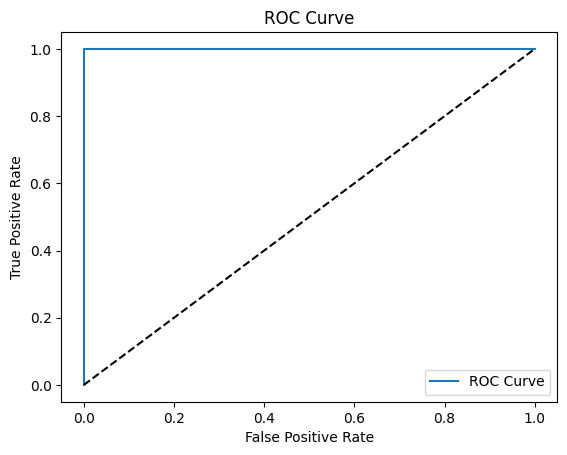


AUC Score: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("\nAUC Score:", roc_auc_score(y_test, y_proba))


In [ ]:
# for x, y_true, y_hat in zip(X_test, y_test, y_pred):
#     print(f"Review: {x}\nActual: {y_true}, Predicted: {y_hat}\n")


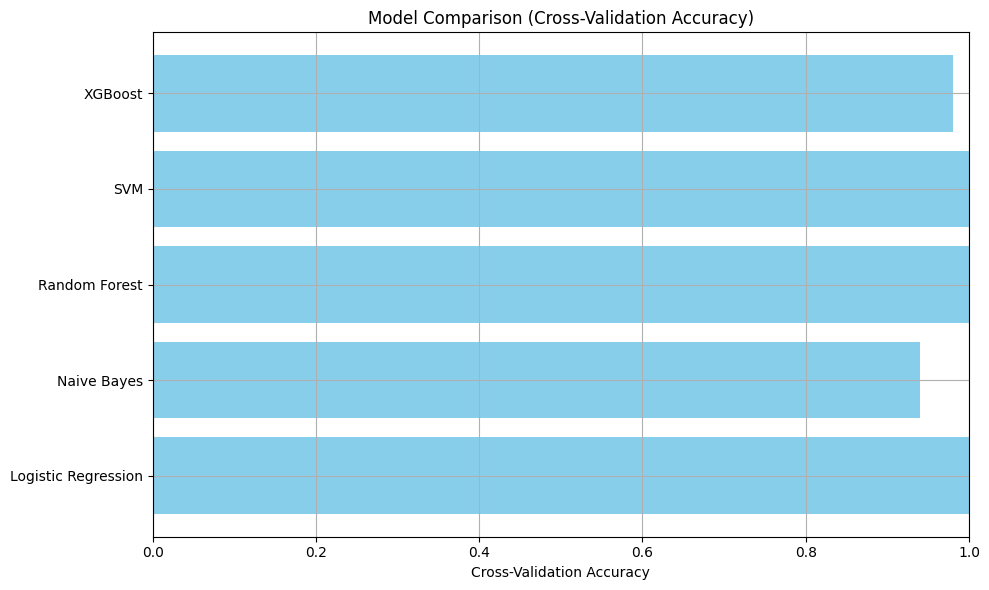

Logistic Regression - Mean Accuracy: 1.0000
Naive Bayes - Mean Accuracy: 0.9400
Random Forest - Mean Accuracy: 1.0000
SVM - Mean Accuracy: 1.0000
XGBoost - Mean Accuracy: 0.9800


In [ ]:
# import xgboost as xgb
# from sklearn.svm import SVC
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_extraction.text import CountVectorizer

# # Initialize the CountVectorizer
# vectorizer = CountVectorizer(stop_words='english')

# # Joining sentiment lists into one string
# df['Sentiment_Combined'] = df['Sentiment'].apply(lambda x: ' '.join(x))

# X = df['Sentiment_Combined']
# y = df['sentiment_label']

# # Vectorizing the text data
# X_vectorized = vectorizer.fit_transform(X)

# models = {
#     "Logistic Regression": LogisticRegression(random_state=42),
#     "Naive Bayes": MultinomialNB(),
#     "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
#     "SVM": SVC(random_state=42),
#     "XGBoost": xgb.XGBClassifier(random_state=42)
# }

# # Store cross-validation scores
# model_names = []
# cv_scores = []

# # Performing 5-fold cross-validation for each model
# for name, model in models.items():
#     scores = cross_val_score(model, X_vectorized, y, cv=5, scoring='accuracy')
#     model_names.append(name)
#     cv_scores.append(scores.mean())

# plt.figure(figsize=(10, 6))
# plt.barh(model_names, cv_scores, color='skyblue')
# plt.xlabel('Cross-Validation Accuracy')
# plt.title('Model Comparison (Cross-Validation Accuracy)')
# plt.xlim(0, 1)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# for name, score in zip(model_names, cv_scores):
#     print(f"{name} - Mean Accuracy: {score:.4f}")
